```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

Notebook for generating plots of the results of NorKyst-800 experiments
for use in our paper.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime



from matplotlib import animation, rc
from matplotlib import pyplot as plt

from IPython.display import clear_output

#Set large figure sizes
plt.rcParams["animation.html"] = "jshtml" #Javascript 
#plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 600 #highres movies/plots (nice for web)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import PlotHelper, Common, WindStress, IPythonMagic, OceanographicUtilities

In [3]:
#%setup_logging -o lofoten_sim.log
%cuda_context_handler gpu_ctx

# Select area and result folder

In [4]:


#case = 1 # Open waters in the Norwegian Sea
case = 2 # Lofoten
#case = 3 # The Norwegian Coast

casename = 'norwegian_sea_'


if case == 2:
    casename = 'lofoten_'
    
if case == 3:
    casename = 'complete_coast_'
    
folder = "not_defined"

### Overrule the above folder name:
### Result files on havahol desktop
#folder = 'sim_results/2019-11-27/norwegian_sea/'
#folder = 'sim_results/2019-11-27/lofoten/'
#folder = 'sim_results/2019-11-27/complete_coast/'
folder = '2023-02-22\\lofoten'

assert(folder.find(casename[:-1]) > -1), 'folder does not start with casename!'
print(folder)

2023-02-22\lofoten


# Inspect URL and select area

In [5]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

local_norkyst800_url_havahol = '/media/havahol/Seagate Backup Plus Drive/gpu_ocean/cdklm_practicalities/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url
    
filename = os.path.abspath(os.path.basename(source_url))
cache_folder='netcdf_cache'
cache_filename = os.path.abspath(os.path.join(cache_folder,
                                              os.path.basename(source_url)))

if (os.path.isfile(filename)):
    source_url = filename

elif (os.path.isfile(cache_filename)):
    source_url = cache_filename

print(source_url)
    

c:\Users\havardh\playground-win\gpuocean\miscGPUOcean\realWorldSim\NorKyst-800m_ZDEPTHS_his.an.2019071600.nc


In [6]:
try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    angle = np.array(ncfile.variables['angle'])
    print(H_full.shape)
    lat = np.array(ncfile.variables["lat"])
    lon = np.array(ncfile.variables["lon"])
except Exception as e:
    raise e

finally:
    ncfile.close()

(902, 2602)


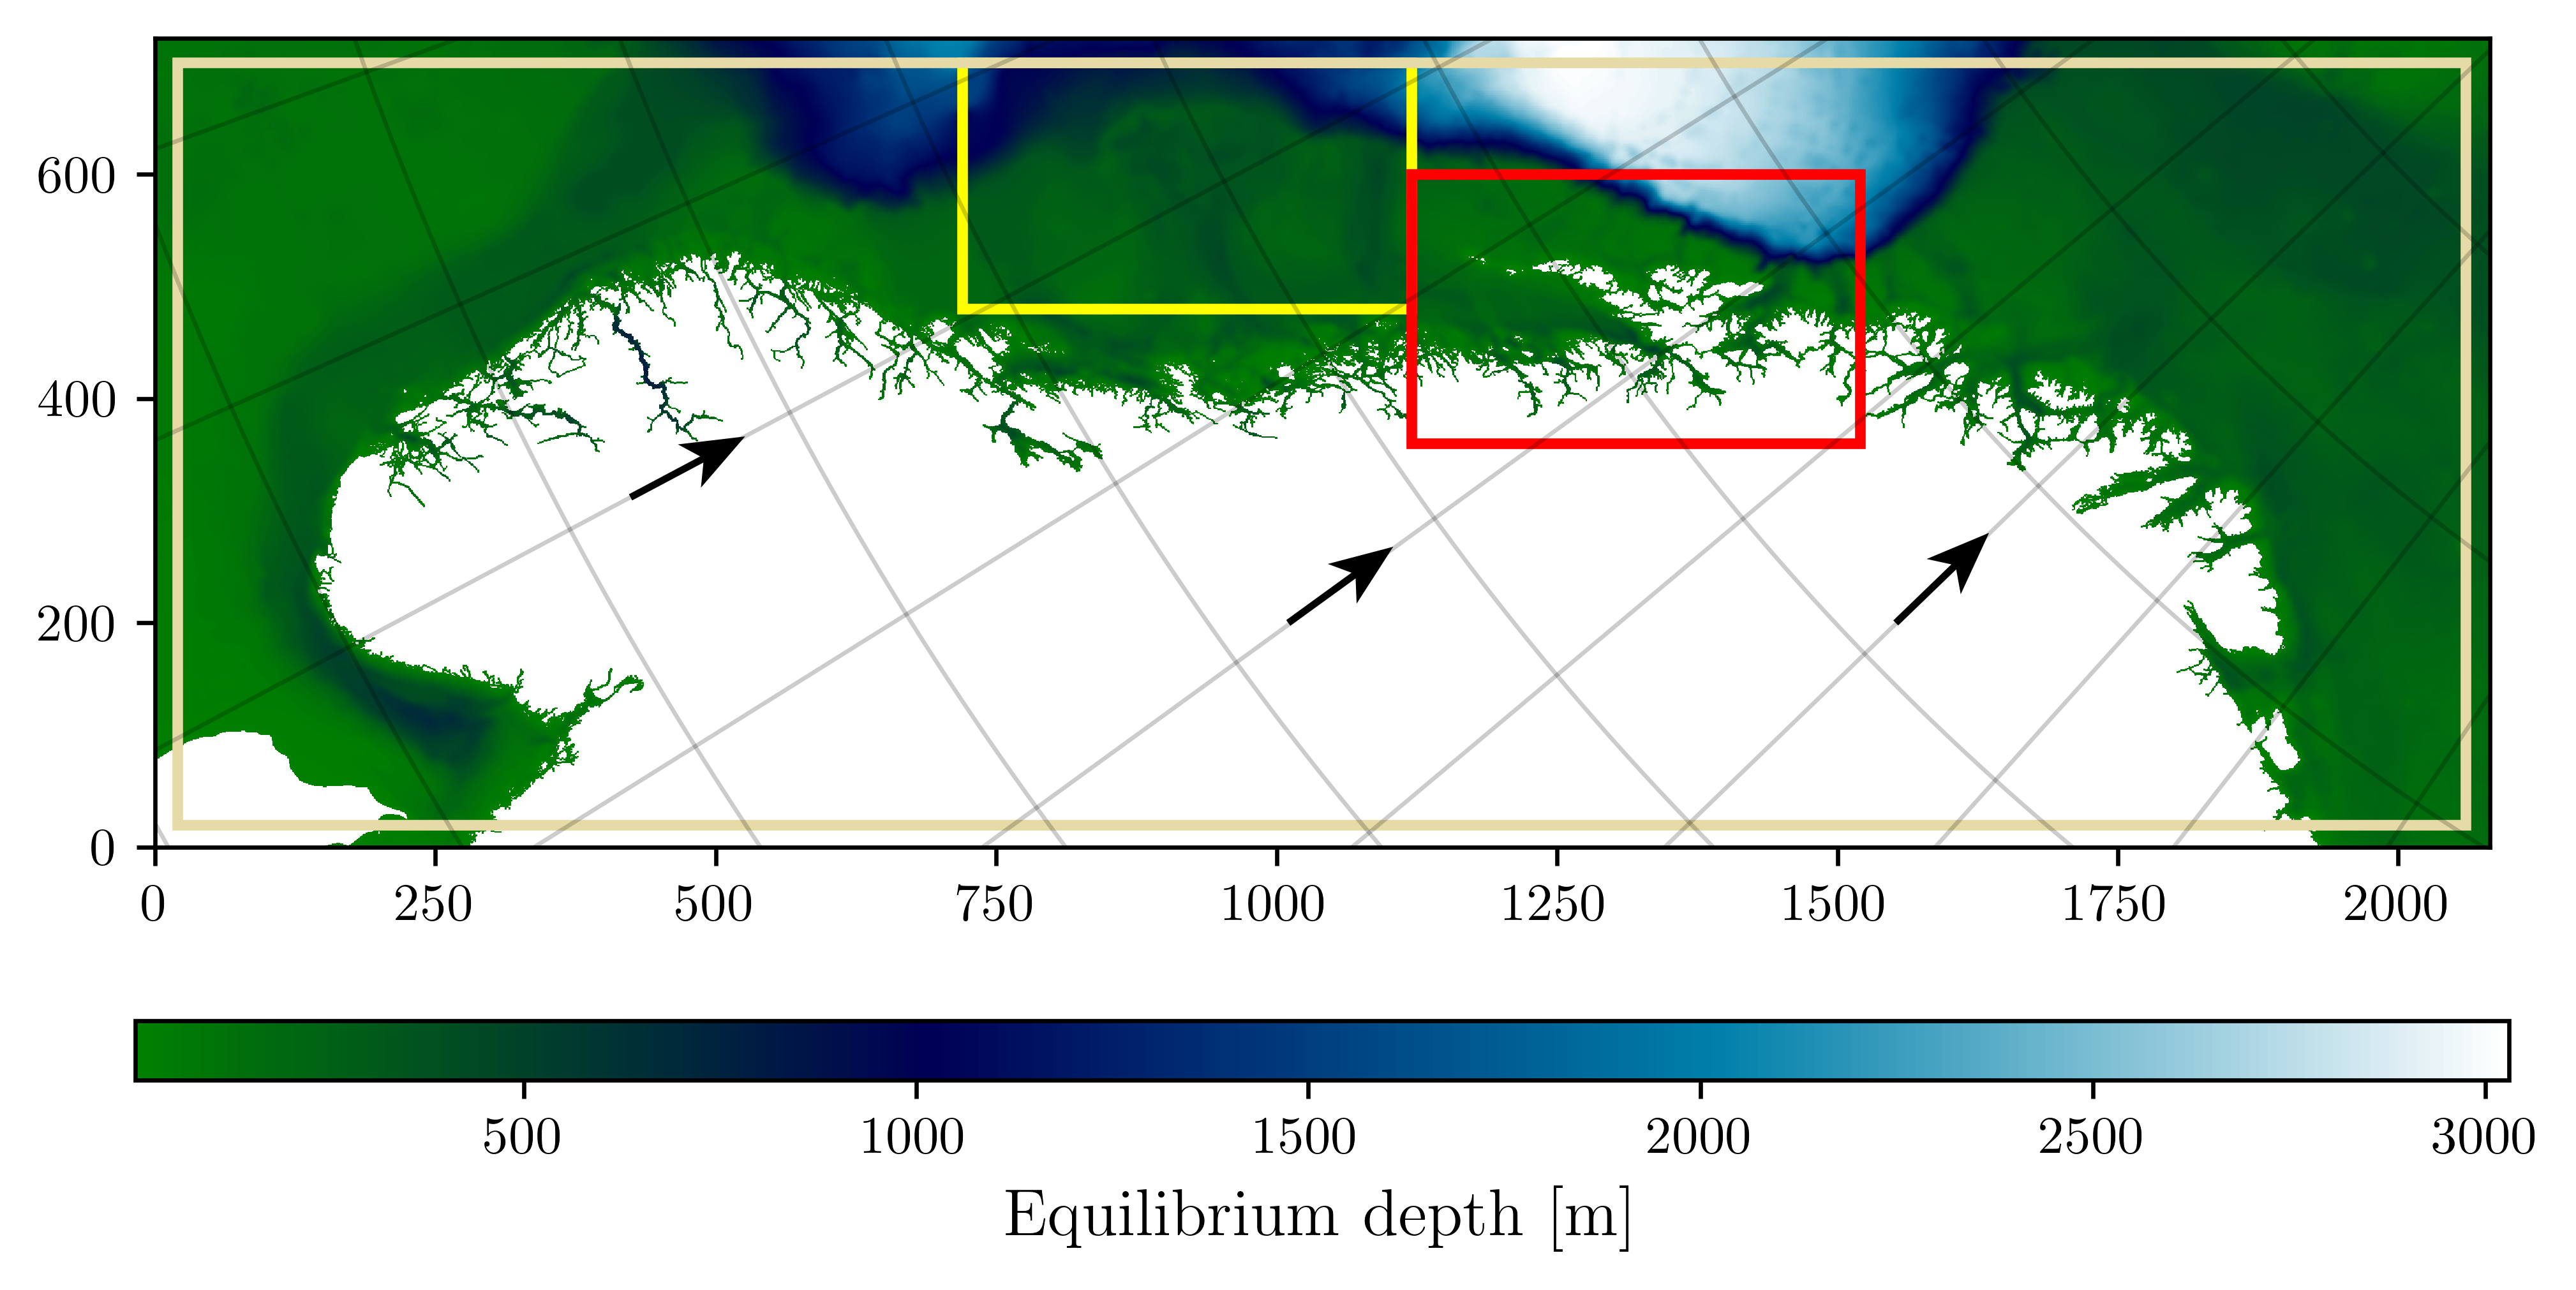

In [7]:
##### 
case2_x0 = 1400
case2_x1 = int(case2_x0 + 500)
case2_y0 = 450
case2_y1 = int(case2_y0 + 300)

#x0 = 1650
#x1 = int(x0 + 100)
#y0 = 450
#y1 = int(y0 + 200)

case1_x0 = 900
case1_x1 = 1400
case1_y0 = 600
case1_y1 = 875


case3_x0 = 25
case3_x1 = 2575
case3_y0 = 25
case3_y1 = 875


land_value = H_full.min()
(full_ny, full_nx) = H_full.shape

# Makes sure axis are in km (assuming equidistant 800x800m grid)
extent=np.array([0, full_nx*0.8, 0, full_ny*0.8])


fig = plt.figure(figsize=(8,4))

# Land and bathymetry
land = np.ma.masked_where(H_full == land_value, H_full)
im = plt.imshow(land, interpolation="None", origin='lower', cmap='ocean',
           extent=extent)

cbar = fig.colorbar(im, orientation='horizontal', aspect=40)
cbar.set_label('Equilibrium depth [m]', size=12.5)


# Case boxes
fig.gca().fill(np.array([case1_x0, case1_x0, case1_x1, case1_x1])*0.8, 
               np.array([case1_y0, case1_y1, case1_y1, case1_y0])*0.8, 
               fill=False, linestyle='-', linewidth=2, color='yellow')
fig.gca().fill(np.array([case2_x0, case2_x0, case2_x1, case2_x1])*0.8, 
               np.array([case2_y0, case2_y1, case2_y1, case2_y0])*0.8, 
               fill=False, linestyle='-', linewidth=2, color='red')

# Save without north arrow
plt.savefig(os.path.join(folder, 'caseLocationsInNorway.pdf'))
plt.savefig(os.path.join(folder, 'caseLocationsInNorway.png'))


fig.gca().fill(np.array([case3_x0, case3_x0, case3_x1, case3_x1])*0.8, 
               np.array([case3_y0, case3_y1, case3_y1, case3_y0])*0.8, 
               fill=False, linestyle='-', linewidth=2, color='xkcd:beige')

plt.savefig(os.path.join(folder, 'caseLocationsInNorway_3cases.pdf'))
plt.savefig(os.path.join(folder, 'caseLocationsInNorway_3cases.png'))

plt.contour(lon, levels = np.arange(0, 40, 4), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
plt.contour(lat, levels = np.arange(56,77, 2), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

plt.savefig(os.path.join(folder, 'caseLocationsInNorway_3cases_latlon.pdf'))
plt.savefig(os.path.join(folder, 'caseLocationsInNorway_3cases_latlon.png'))
                                                                                    
                                                                                            
# Create north arrows 
quiv_y1 = 390
quiv_y = 250
quiv_x1 = 530 #265
quiv_x2 = 1263
quiv_x4 = 1940
plt.quiver(np.array([quiv_x1, quiv_x2, quiv_x4])*0.8, 
           np.array([quiv_y1, quiv_y, quiv_y])*0.8, 
           [np.sin(angle[quiv_y1, quiv_x1]), np.sin(angle[quiv_y, quiv_x2]),
            np.sin(angle[quiv_y, quiv_x4])], 
           [np.cos(angle[quiv_y1, quiv_x1]), np.cos(angle[quiv_y, quiv_x2]),
            np.cos(angle[quiv_y, quiv_x4])], 
           color='k', width=0.003, 
           headwidth=7, headlength=9, headaxislength=7)

plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases_latlon.pdf'))
plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases_latlon.png'))




In [8]:
## Select case

x0 = case1_x0
x1 = case1_x1
y0 = case1_y0
y1 = case1_y1

if case == 2:
    x0 = case2_x0
    x1 = case2_x1
    y0 = case2_y0
    y1 = case2_y1
    print('using the Lofoten case')

elif case == 3:
    x0 = case3_x0
    x1 = case3_x1
    y0 = case3_y0
    y1 = case3_y1
    print('using the complete coast case')

else:

    print('using Norwegian Sea area')


using the Lofoten case


In [9]:
# Make variables containing lat-lon for each case (in original resolution)
lat_case1 = lat[case1_y0:case1_y1, case1_x0:case1_x1]
lon_case1 = lon[case1_y0:case1_y1, case1_x0:case1_x1]
lat_case2 = lat[case2_y0:case2_y1, case2_x0:case2_x1]
lon_case2 = lon[case2_y0:case2_y1, case2_x0:case2_x1]
lat_case3 = lat[case3_y0:case3_y1, case3_x0:case3_x1]
lon_case3 = lon[case3_y0:case3_y1, case3_x0:case3_x1]


In [10]:
H_full = None

In [11]:
folder

'2023-02-22\\lofoten'

# Plotting results

In [12]:
9*1.5, 3.4*1.5

(13.5, 5.1)

In [13]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


def paperFig(eta, hu, hv, H_m, x, y, 
             interpolation="None", title=None, figsize=(13.5, 5.1),
             save_filename=None, main_title=None, savethis=False):
    
    # early preprint: figsize=(9, 3.4) 
    
    fig, axs = plt.subplots(1,2, figsize=figsize)
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    clevels= np.arange(np.floor(eta.min()*5)/5, np.ceil(eta.max()*5)/5, 0.2)
    if x0 == case1_x0:
        clevels= np.arange(np.floor(eta.min()*10)/10, np.ceil(eta.max()*10)/10, 0.1)
        
    assert(len(clevels) < 51), 'clevels contains ' + str(len(clevels)) + ' levels!!'
    
    extent_x0 = x0*800
    extent_y0 = y0*800
    
    extent=np.array([extent_x0, x[-1]+extent_x0, extent_y0, y[-1]+extent_y0]) / 1000
    
    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = eta.mask
    
    # Colormaps
    eta_cmap = plt.cm.BrBG
    v_cmap=plt.cm.Oranges
    
    # Set land color
    #land_color = 'xkcd:grey green' # 'grey'
    land_color = 'grey'
    v_cmap.set_bad(land_color, alpha=1.0)
    eta_cmap.set_bad(land_color, alpha=1.0)
    
    # Specifying hard vlims
    eta_max = 2.1
    v_max = 0.42
    
    fontsize = 18
    if save_filename == 'complete_coast_':
        fontsize = 14
        main_title = main_title.replace('resolution', 'res.')
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=-eta_max, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, "$\eta$ [m]")
    eta_cs = axs[0].contour(eta, clevels, colors='k', origin='lower', corner_mask=True, linestyles='dashed', extent=extent)
    axs[0].clabel(eta_cs, eta_cs.levels, inline=True, fontsize=7, fmt='%1.1f', use_clabeltext=True)
    
    hv_im = axs[1].imshow(V, interpolation=interpolation, origin='lower',
                          vmin=0, vmax=v_max, extent=extent, cmap=v_cmap)
    addColorbar(axs[1], hv_im, "particle velocity [m/s]")
    
    # Show lat-lon grid
    lon_freq = 2
    lat_freq = 1
    if case == 1:
        spec_lon = lon_case1
        spec_lat = lat_case1
    if case == 2:
        spec_lon = lon_case2
        spec_lat = lat_case2
    if case == 3:
        spec_lon = lon_case3
        spec_lat = lat_case3
        lon_freq = 4
        lat_freq = 2
    
    if main_title is not None:
        axs[0].set_ylabel(main_title, labelpad=3, fontsize=fontsize)
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    
    print(save_filename)
    if save_filename is not None and savethis:
        print(os.path.join(folder, save_filename))
        fig.savefig(os.path.join(folder, save_filename + ".png"), dpi=600, bbox_inches='tight')
        fig.savefig(os.path.join(folder, save_filename + ".pdf"), bbox_inches='tight')
        
    for i in [0, 1]:
        cont_lon_case = axs[i].contour(spec_lon, levels = np.arange(0, 40, lon_freq), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
        cont_lat_case = axs[i].contour(spec_lat, levels = np.arange(56,77, lat_freq), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
    if save_filename is not None and savethis:
        print(os.path.join(folder, save_filename), ' with lat-lon!')
        fig.savefig(os.path.join(folder, save_filename + "_latlon.png"), dpi=600, bbox_inches='tight')
        fig.savefig(os.path.join(folder, save_filename + "_latlon.pdf"), bbox_inches='tight')
        plt.close()
        
def lofoten_from_complete_array_picking(eta, hu, hv, H_m, x, y):
    # Lofoten:  case 2
    # complete: case 3

    case3_nx = case3_x1 - case3_x0
    case3_ny = case3_y1 - case3_y0
    eta_ny, eta_nx = eta.shape

    cut_x0 = case2_x0 - case3_x0
    cut_x1 = case2_x1 - case3_x1
    cut_y0 = case2_y0 - case3_y0
    cut_y1 = case2_y1 - case3_y1

    if eta_ny < case3_ny:
        print('low resolution')
        cut_x0 = np.int(cut_x0/2)
        cut_x1 = np.int(cut_x1/2)
        cut_y0 = np.int(cut_y0/2)
        cut_y1 = np.int(cut_y1/2)
    if eta_ny > case3_ny:
        print('high resolution')
        cut_x0 = cut_x0*2
        cut_x1 = cut_x1*2
        cut_y0 = cut_y0*2
        cut_y1 = cut_y1*2

    eta = eta[cut_y0:cut_y1, cut_x0:cut_x1]
    hu  =  hu[cut_y0:cut_y1, cut_x0:cut_x1]
    hv  =  hv[cut_y0:cut_y1, cut_x0:cut_x1]
    H_m = H_m[cut_y0:cut_y1, cut_x0:cut_x1]
    x   =   x[cut_x0:cut_x1]
    y   =   y[cut_y0:cut_y1]
    x = x - x[0]
    y = y - y[0]
        
    return eta, hu, hv, H_m, x, y


def plotSingleReferenceStep(source_url, hour=-1, savethis=False, lofoten_from_complete=False):
    
    hour = hour%24
    save_filename = casename+'norkyst800_'+str(hour).zfill(2)
    title = 'NorKyst-800 ' + str(hour)
    main_title = 'NorKyst-800'
    
    ncfile = None
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0:y1, x0:x1]
        eta = ncfile.variables['zeta'][hour, y0:y1, x0:x1]
        hu = ncfile.variables['ubar'][hour, y0:y1, x0:x1]
        hv = ncfile.variables['vbar'][hour, y0:y1, x0:x1]
        
        x = ncfile.variables['X'][x0:x1]
        y = ncfile.variables['Y'][y0:y1]
        x = x - x[0]
        y = y - y[0]
        
        hu = hu * (H_m + eta)
        hv = hv * (H_m + eta)
        
    except Exception as e:
        raise e
    finally:
        ncfile.close()
        
    H_m.mask = eta.mask
    
    if lofoten_from_complete:
        eta, hu, hv, H_m, x, y = lofoten_from_complete_array_picking(eta, hu, hv, H_m, x, y)
        save_filename = 'lofoten_' + save_filename

    paperFig(eta, hu, hv, H_m, x, y,  title=title, main_title=main_title,
             save_filename=save_filename, savethis=savethis)
    
def plotSingleTimeStep(filename, main_title, hour=-1, savethis=False, lofoten_from_complete=False):
    
    str_hour = hour%24
    print("hour, str_hour: ", hour, str_hour)
    save_filename = filename.replace('.nc', '_'+str(str_hour).zfill(2))
    title = filename.replace('_', ' ').replace('.nc', ' ') + str(str_hour)
    filename = os.path.join(folder, filename)
    print("filename: ", filename)
    
    ncfile = None
    try:
        ncfile = Dataset(filename)

        x = ncfile.variables['x'][:]
        y = ncfile.variables['y'][:]
        t = ncfile.variables['time'][hour]

        H_m = ncfile.variables['Hm'][:,:]
        eta = ncfile.variables['eta'][hour,:,:]
        hu = ncfile.variables['hu'][hour,:,:]
        hv = ncfile.variables['hv'][hour,:,:]
    except Exception as e:
        raise e
    finally:
        if ncfile is not None:
            ncfile.close()
    
    if hour == 0:
        print('Info for ' + filename)
        print("shape Hm: ", H_m.shape)
        num_cells = H_m.shape[0]*H_m.shape[1]
        print("total number of cells ", num_cells)
        print("Dry cells, found by H_m.mask.sum(): ", H_m.mask.sum())
        print("Wet cells", num_cells - H_m.mask.sum())
        print("ratio of wet cells: ", str((num_cells - H_m.mask.sum())/num_cells))
    
    if lofoten_from_complete:
        eta, hu, hv, H_m, x, y = lofoten_from_complete_array_picking(eta, hu, hv, H_m, x, y)
        save_filename = 'lofoten_' + save_filename
        
    paperFig(eta, hu, hv, H_m, x, y,  title=title, main_title=main_title,
             save_filename=save_filename, savethis=savethis)
        
def randomtesting():
    test_ma = hu[:,:].copy()
    print(type(test_ma))
    fig = plt.figure(figsize=(6,4))
    cmap = plt.cm.viridis
    cmap.set_bad('white',1.)
    
    test_ma.mask = H_m.mask
    test_ma.data[test_ma.mask]=300

    
    plt.imshow(test_ma, origin='lower', cmap=cmap)
    plt.colorbar()
    print(test_ma.mask)
    print(H_m.min(), H_m.max(), np.sum(H_m.mask), H_m.shape[0]*H_m.shape[1])
    print(np.sum(test_ma.mask), test_ma.shape[0]*test_ma.shape[1])
    
    
    ### Test with contour plot for eta:
    fig = plt.figure(figsize=(6,4))
    
    eta_max = np.max(np.abs(eta))
    levels= np.arange(-eta_max, eta_max, 0.2)


    plt.imshow(eta, cmap='BrBG', origin='lower', vmin=-eta_max, vmax=eta_max)
    plt.contour(eta, levels, colors='k', origin='lower', corner_mask=True, linestyles='dashed')
    
    ### Test with contour plot for eta:
    fig = plt.figure(figsize=(6,4))
    
    eta_max = np.max(np.abs(eta))
    levels= np.arange(-np.ceil(eta_max), np.ceil(eta_max), 0.2)


    plt.imshow(eta, cmap='BrBG', origin='lower', vmin=-eta_max, vmax=eta_max)
    CS = plt.contour(eta, levels, colors='k', origin='lower', corner_mask=False, linestyles='dashed')
    plt.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%1.1f')

    
main_title_orig = 'Original resolution'
main_title_high = 'High resolution'
main_title_low  = 'Low resolution'
if case == 3:
    main_title_orig = 'Original res.'
    main_title_high = 'High res.'
    main_title_low  = 'Low res.'


#hour = 23
savethis = True
for hour in [-1]:
    plotSingleTimeStep(casename+'original.nc', main_title_orig, 
                       hour=hour, savethis=savethis)
    plotSingleTimeStep(casename+'highres.nc', main_title_high,
                       hour=hour, savethis=savethis)
    plotSingleTimeStep(casename+'lowres.nc',  main_title_low,
                       hour=hour, savethis=savethis)
    plotSingleReferenceStep(source_url, 
                            hour=hour, savethis=savethis)

if case == 3 and False:
    for hour in [23]:
        plotSingleTimeStep(casename+'original.nc', 'Original resolution', 
                           hour=hour, savethis=savethis, lofoten_from_complete=True)
        plotSingleTimeStep(casename+'highres.nc', 'High resolution',
                           hour=hour, savethis=savethis, lofoten_from_complete=True)
        plotSingleTimeStep(casename+'lowres.nc',  'Low resolution',
                           hour=hour, savethis=savethis, lofoten_from_complete=True)
        plotSingleReferenceStep(source_url, 
                                hour=hour, savethis=savethis, lofoten_from_complete=True)

c:\Users\havardh\Miniconda3\envs\gpuocean\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  
c:\Users\havardh\Miniconda3\envs\gpuocean\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))
c:\Users\havardh\Miniconda3\envs\gpuocean\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.c

hour, str_hour:  -1 23
filename:  2023-02-22\lofoten\lofoten_original.nc
lofoten_original_23
2023-02-22\lofoten\lofoten_original_23
2023-02-22\lofoten\lofoten_original_23  with lat-lon!
hour, str_hour:  -1 23
filename:  2023-02-22\lofoten\lofoten_highres.nc
lofoten_highres_23
2023-02-22\lofoten\lofoten_highres_23
2023-02-22\lofoten\lofoten_highres_23  with lat-lon!
hour, str_hour:  -1 23
filename:  2023-02-22\lofoten\lofoten_lowres.nc
lofoten_lowres_23
2023-02-22\lofoten\lofoten_lowres_23
2023-02-22\lofoten\lofoten_lowres_23  with lat-lon!
lofoten_norkyst800_23
2023-02-22\lofoten\lofoten_norkyst800_23
2023-02-22\lofoten\lofoten_norkyst800_23  with lat-lon!


In [14]:
folder

'2023-02-22\\lofoten'

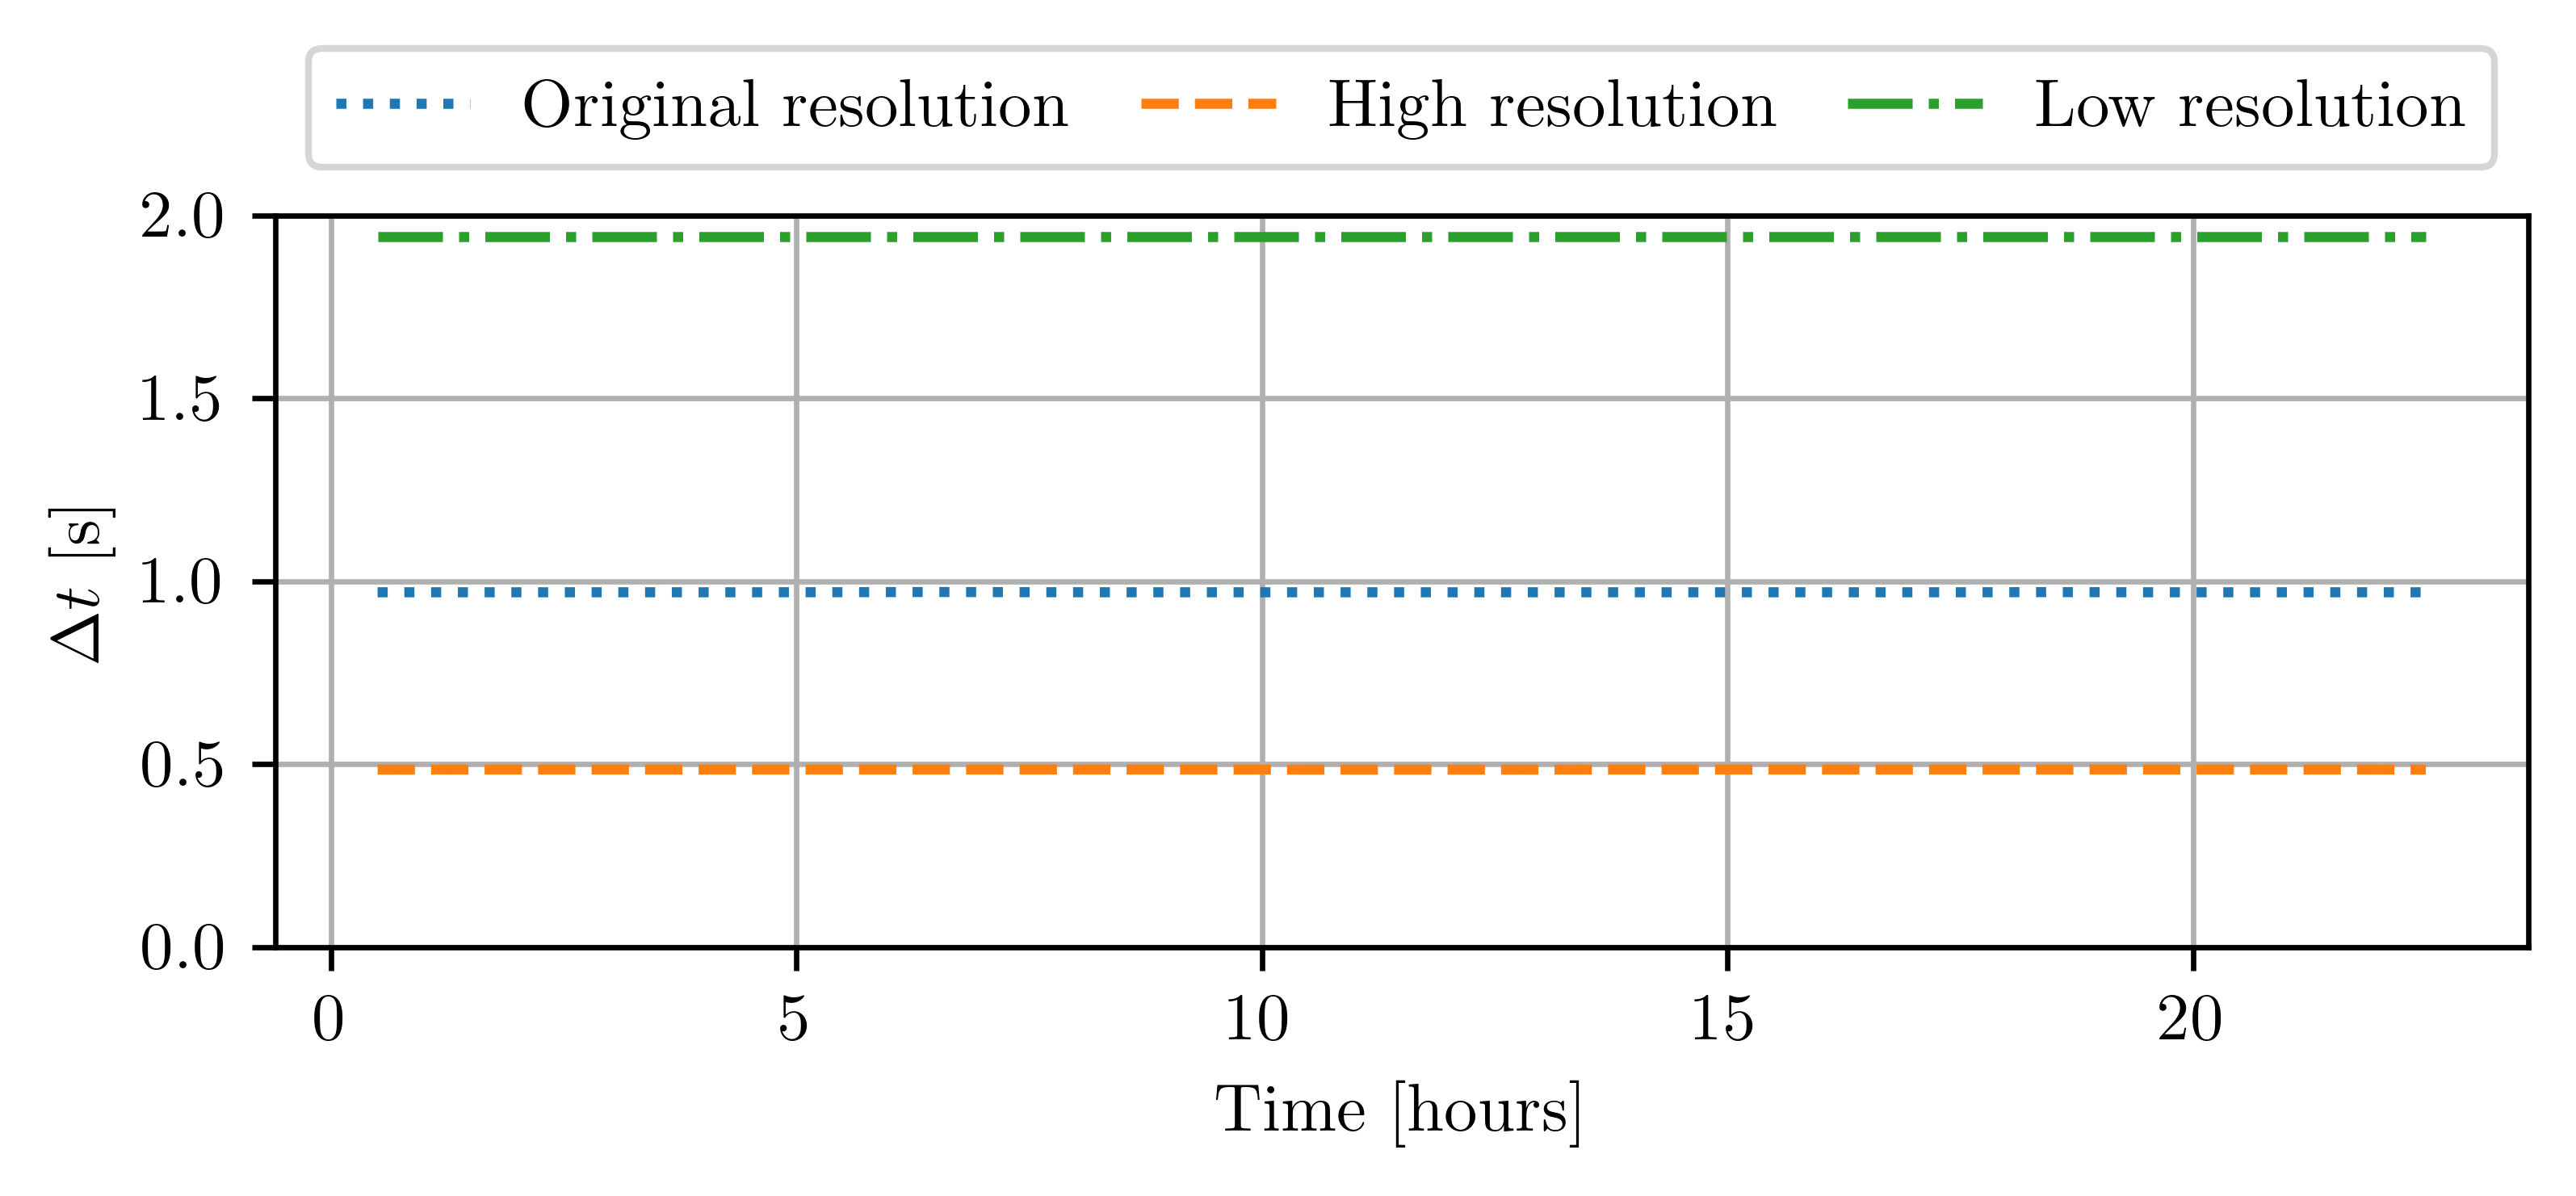

In [15]:
def plotAllStatistics(filenames, labels, single_figs=False):
    
    patterns = [':', '--', '-.']
    
    assert(len(filenames) == len(labels))

    if not single_figs:
        plt.figure(figsize=(6,2))

    for i in range(len(filenames)):
        filename = filenames[i]
        label = labels[i]
        pattern = patterns[i]
        
        if single_figs:
            plt.figure(figsize=(12,4))
    
        filename = os.path.join(folder, filename)
        try:
            ncfile = Dataset(filename)
            t = ncfile.variables['time'][:]
            num_iterations = ncfile.variables['num_iterations'][:]

            num_timesteps = len(t)
            max_abs_u = np.zeros(num_timesteps)
            max_abs_v = np.zeros(num_timesteps)

            H_m = ncfile.variables['Hm'][:,:]

            for i in range(num_timesteps):
                h = H_m + ncfile.variables['eta'][i,:,:]

                u = ncfile.variables['hu'][i,:,:] / h
                v = ncfile.variables['hv'][i,:,:] / h

                max_abs_u[i] = np.max(np.abs(u))
                max_abs_v[i] = np.max(np.abs(v))


        except Exception as e:
            print("Something went wrong:" + str(e))
            raise e
        finally:
            ncfile.close()

        #plt.title("Statistics")
        #plt.subplot(2,1,1)
        plt.plot(0.5*(t[1:] + t[:-1])/3600, np.diff(t)/np.diff(num_iterations), 
                 pattern, label=label)
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", 
               mode='expand', ncol=3)
    plt.ylim([0, 2])
    plt.grid()
    plt.xlabel('Time [hours]')
    plt.ylabel('$\Delta t$ [s]')
    
    plt.savefig(os.path.join(folder, 'adaptive_dt.pdf'), bbox_inches='tight')
    
    #plt.subplot(2,1,2)
    #plt.plot(t/3600, max_abs_u, label="Max $|u|$")
    #plt.plot(t/3600, max_abs_v, label="Max $|v|$")
    #plt.legend()
        
filenames = [casename+"original.nc",
             casename+"highres.nc",
             casename+"lowres.nc"]
labels = ['Original resolution', 
          'High resolution',
          'Low resolution']


plotAllStatistics(filenames, labels, single_figs=0)